Import libraries

In [24]:
library(forecast)
library(tidyverse)
library(ggplot2)

In [25]:
install.packages("TSPred")


The downloaded binary packages are in
	/var/folders/37/9ncc0zbd061cflxwwq4w1_z00000gn/T//Rtmpts2KJB/downloaded_packages


In [26]:
options(repr.plot.width = 16, repr.plot.height = 9)
options(warn = - 1)

Read data

In [27]:
# Read data
madrid = read_csv("datasets/csvs_per_year/madrid_2001.csv", show_col_types = FALSE)
for (i in 2002:2018){
    url = paste("datasets/csvs_per_year/madrid_", i, ".csv", sep='')
    madrid = bind_rows(madrid, read_csv(url, show_col_types = FALSE))  
}

Pre-processing data

In [28]:
madrid$date <- as.POSIXct(madrid$date, format = "%Y-%m-%d %H:%M:%S")
madrid = madrid %>%
  select(date,NO_2, O_3, PM10)
  
# Add day, month and year variables
madrid$day <- format(madrid$date, "%d")
madrid$month <- format(madrid$date, "%m")
madrid$year <- format(madrid$date, "%Y")

We use NO2, O3 and PM10 as these are core pollutants based on airqualitynow.eu

In [29]:
# Convert to CAQI
madrid = madrid %>%
mutate(NO_2 = NO_2 / 4,
       O_3 = O_3 / 2.4,
       PM10 = PM10 / 1.8)

In [30]:
# Get daily peak CAQI
madrid_peak_daily = madrid %>%
  group_by(year, month, day) %>%
  summarise(NO_2 = max(NO_2, na.rm = TRUE),
            O_3  = max(O_3, na.rm = TRUE),
            PM10 = max(PM10, na.rm = TRUE))

head(madrid_peak_daily)

`summarise()` has grouped output by 'year', 'month'. You can override using the `.groups` argument.



year,month,day,NO_2,O_3,PM10
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
2001,01,01,28.5750,34.65000,88.55555
2001,01,02,27.1250,42.16667,60.16667
2001,01,03,27.8250,24.15833,63.16666
2001,01,04,27.4750,28.12500,95.38889
2001,01,05,25.5750,20.64167,73.72222
2001,01,06,24.8925,26.14167,34.01111


### Monthly Moving Average of Madrid's Air Quality

We take the mean of 3 CAQIs (mentioned before) as a Air Quality Index in Madrid and make an average each month.

`summarise()` has grouped output by 'year'. You can override using the `.groups` argument.



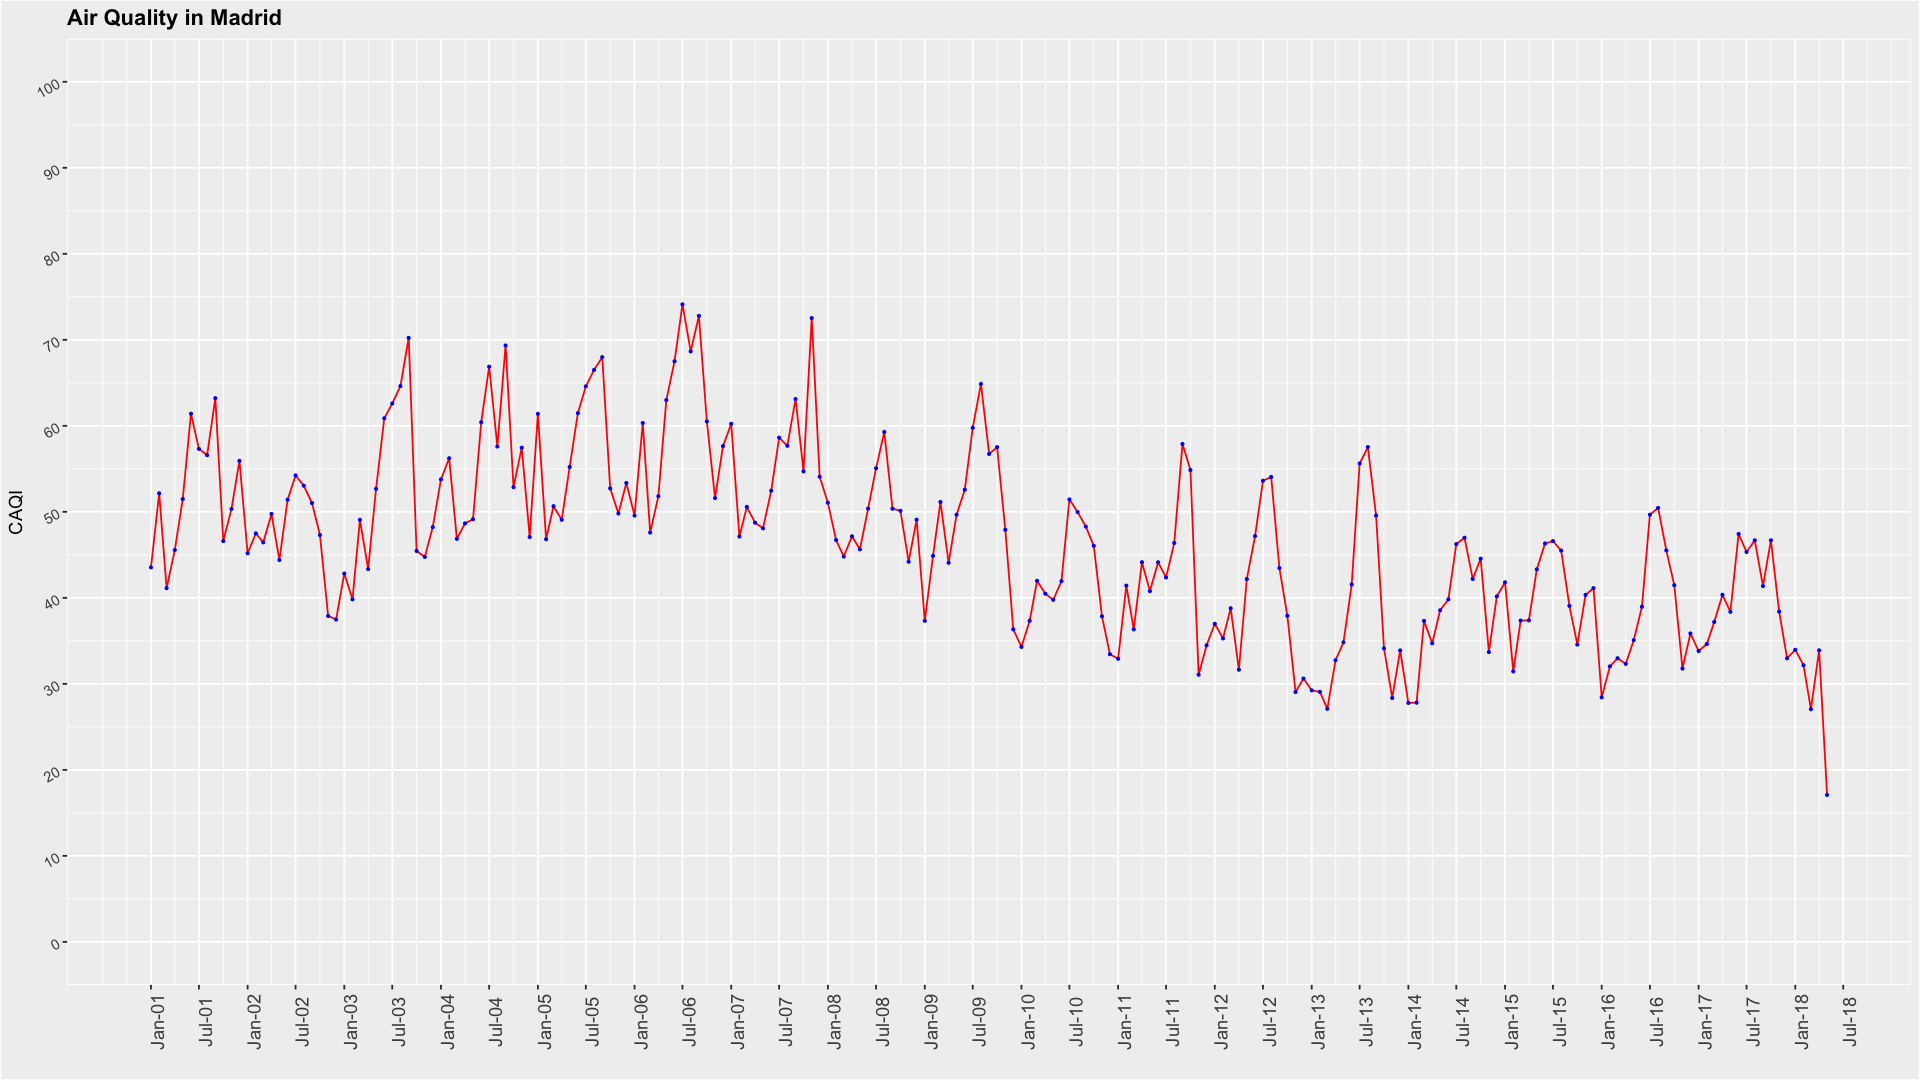

In [31]:
madrid_mean_monthly <- madrid_peak_daily %>%
  group_by(year, month) %>%
  summarise(NO_2 = mean(NO_2, na.rm = TRUE),
            O_3  = mean(O_3, na.rm = TRUE),
            PM10 = mean(PM10, na.rm = TRUE)) %>%
  mutate(time = paste(year, "-", month, "- 01"))

madrid_mean_monthly$tot <- rowMeans(madrid_mean_monthly[,3:5], na.rm = TRUE)

madrid_mean_monthly$time <- as.Date(madrid_mean_monthly$time, format = "%Y - %m - %d")
madrid_mean_monthly$year <- format(madrid_mean_monthly$time, "%Y")

ggplot(madrid_mean_monthly, aes(x = time, y = tot)) + geom_line(color = 'red') + 
  geom_point(aes(x = time, y = tot), size = 0.5, color = 'blue') +
  theme(axis.text.x = element_text(angle = 90),
        legend.position = "none",
        panel.background = element_rect(fill = "gray94", colour = "white",
                                        size = 0.5, linetype = "solid"),
        legend.background = element_rect(fill = "gray94"),
        plot.background = element_rect(fill = "gray94"),
        panel.grid.major = element_line(size = 0.5, linetype = 'solid', colour = "white"), 
        panel.grid.minor = element_line(size = 0.25, linetype = 'solid', colour = "white"),  
        plot.title = element_text(hjust = 0, face = 'bold',color = 'black')) +
  labs(x = '', y = 'CAQI', title='Air Quality in Madrid') +
  theme(axis.text.y =element_text(angle = 30),axis.text.x=element_text(size=11)) +
  scale_x_date(breaks = seq(as.Date("2001-01-01"), as.Date("2018-07-01"), by="6 months"), date_labels = "%b-%y") + 
  scale_y_continuous(breaks = seq(0,100,10), lim = c(0,100))
ggsave('plots/monthly_MA.png', width = 16, height = 9)

### Yearly Moving Average of Madrid's Air Quality

We sum up 10 polutants (mentioned before) as a total polutions in Madrid and make an average each year.

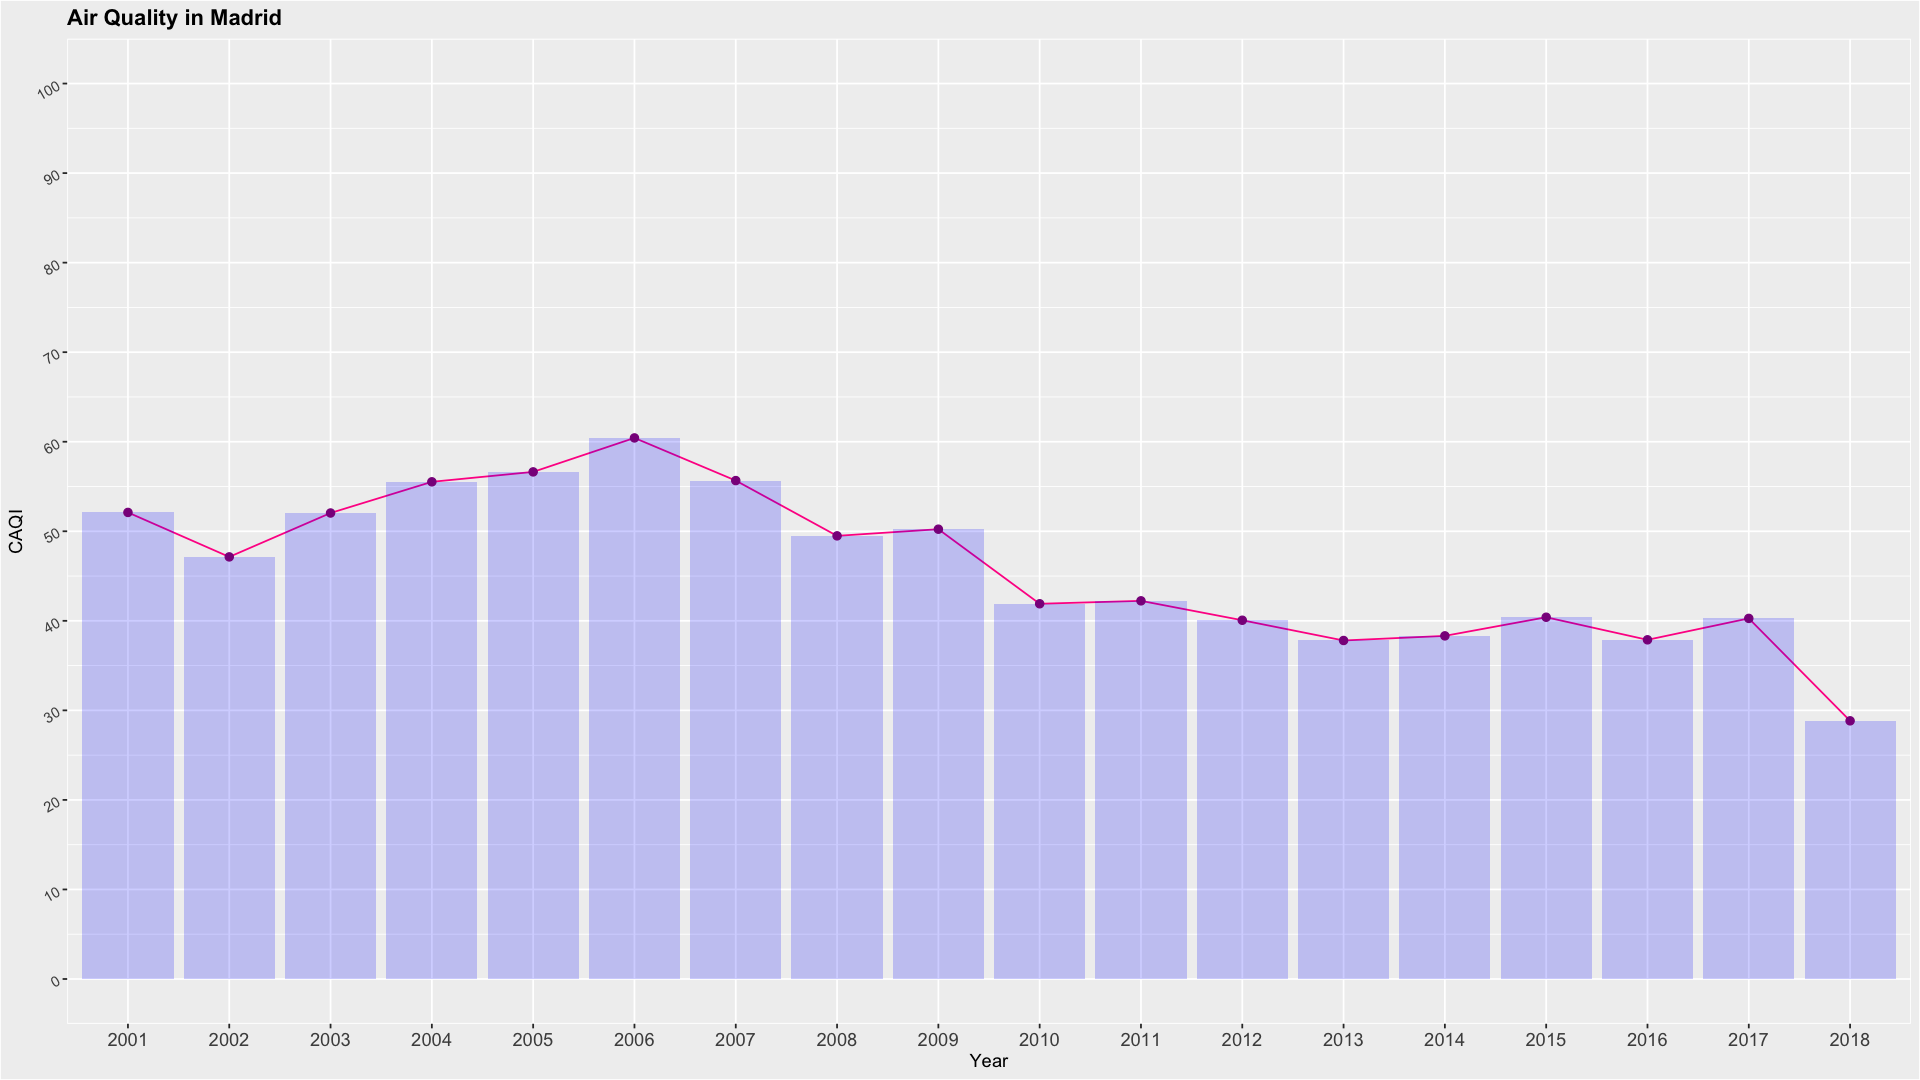

In [32]:
madrid_mean_yearly  <- madrid_mean_monthly %>%
  group_by(year) %>%
  summarise(NO_2 = mean(NO_2, na.rm = TRUE),
            O_3  = mean(O_3, na.rm = TRUE),
            PM10 = mean(PM10, na.rm = TRUE))

madrid_mean_yearly$tot <- rowMeans(madrid_mean_yearly[,2:4], na.rm = TRUE)

ggplot(madrid_mean_yearly, aes(x = year, y = tot, group = 1)) + geom_line(color = 'deeppink') + 
  geom_col(aes(x = year, y = tot), size = 2, fill = 'blue', alpha = 0.2) +
  geom_point(aes(x = year, y = tot), size = 2, color = 'darkmagenta') +
  theme(legend.position = "none",
        panel.background = element_rect(fill = "gray94", colour = "white",
                                        size = 0.5, linetype = "solid"),
        legend.background = element_rect(fill = "gray94"),
        plot.background = element_rect(fill = "gray94"),
        panel.grid.major = element_line(size = 0.5, linetype = 'solid', colour = "white"), 
        panel.grid.minor = element_line(size = 0.25, linetype = 'solid', colour = "white"),  
        plot.title = element_text(hjust = 0, face = 'bold',color = 'black')) +
  labs(x = 'Year', y = 'CAQI', title='Air Quality in Madrid') +
  theme(axis.text.y =element_text(angle = 30),axis.text.x=element_text(size=11)) +
  scale_y_continuous(breaks = seq(0,100,10), lim = c(0,100))
ggsave('plots/yearly_MA.png', width = 16, height = 9)

## Investigate the Increasing Behavior of Air Quality

The idea is averaging polutions each month in every year. From this condition, we will know in which month the polutions increase.

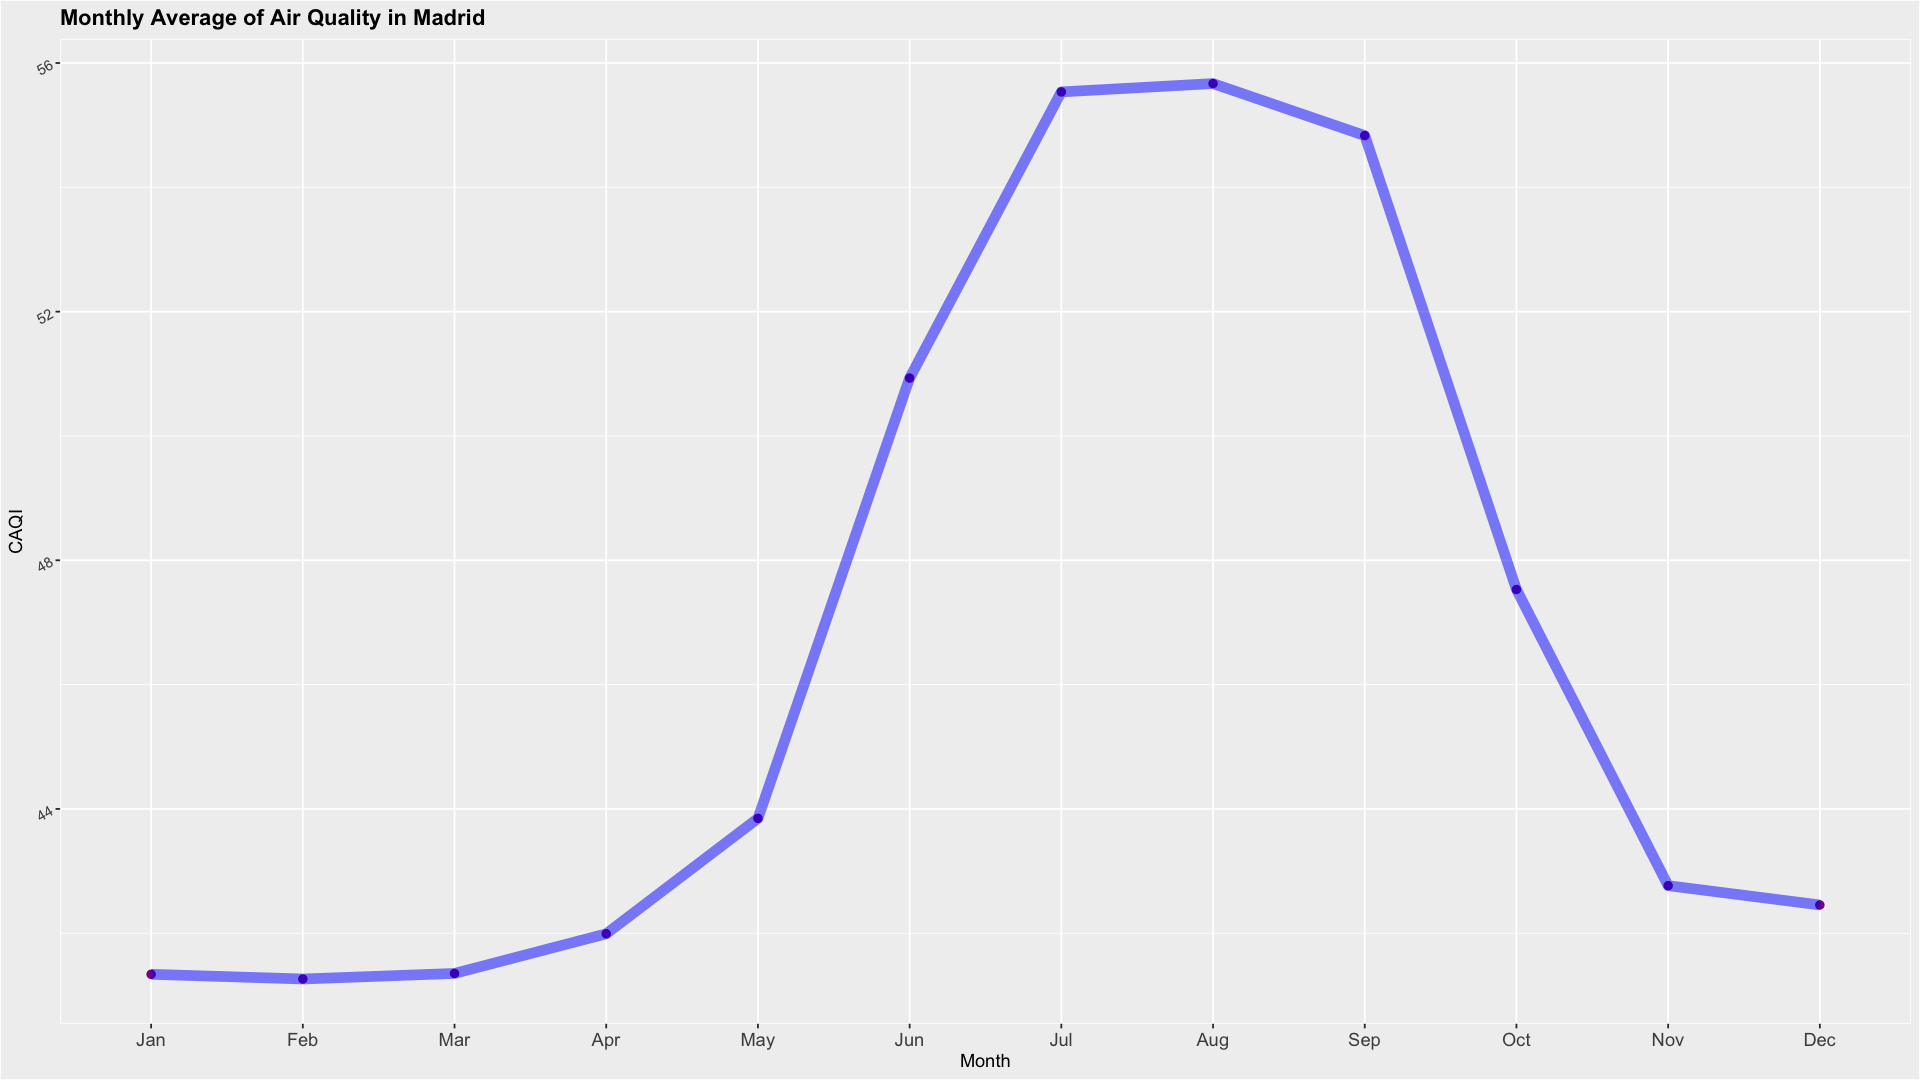

In [33]:
bulan <- c("Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec")

madrid_mean_monthly %>%
  group_by(month) %>%
  summarise(huy=mean(tot)) %>%
  ggplot(aes(x=month, y= huy, group=1)) + 
  geom_point(aes(x = month, y = huy), size = 2, color = 'darkmagenta') + 
  geom_line(size = 3, alpha = 0.5, color = 'blue') +
  scale_x_discrete(labels=bulan) +
    theme(legend.position = "none",
        panel.background = element_rect(fill = "gray94", colour = "white",
                                        size = 0.5, linetype = "solid"),
        legend.background = element_rect(fill = "gray94"),
        plot.background = element_rect(fill = "gray94"),
        panel.grid.major = element_line(size = 0.5, linetype = 'solid', colour = "white"), 
        panel.grid.minor = element_line(size = 0.25, linetype = 'solid', colour = "white"),  
        plot.title = element_text(hjust = 0, face = 'bold',color = 'black')) +
  labs(x = 'Month', y = 'CAQI', title='Monthly Average of Air Quality in Madrid') +
  theme(axis.text.y =element_text(angle = 30),axis.text.x=element_text(size=11))
ggsave('plots/monthly_AVG.png', width = 16, height = 9)

From this graph, we know that air quality is getting worse in summer (June, July, and August). Maybe there are a lot of outdoor activity in Madrid in this season.

## Forecasting using ARIMA model

In [34]:
monthly_ts <- ts(madrid_mean_monthly[,7], start = c(2001,1), end = c(2018, 5), frequency = 12)

### What would happen if 2009 law did not exist?

In [35]:
monthly_ts_before09 <- window(monthly_ts, start = c(2001, 1), end = c(2008, 12))

# Fit an automatic ARIMA model
fit_ts = auto.arima(monthly_ts_before09)
fit_ts

Series: monthly_ts_before09 
ARIMA(1,0,1)(2,1,0)[12] 

Coefficients:
         ar1      ma1     sar1     sar2
      0.9281  -0.6114  -0.8841  -0.4497
s.e.  0.0607   0.1200   0.1073   0.1201

sigma^2 estimated as 35.63:  log likelihood=-272.74
AIC=555.48   AICc=556.25   BIC=567.63

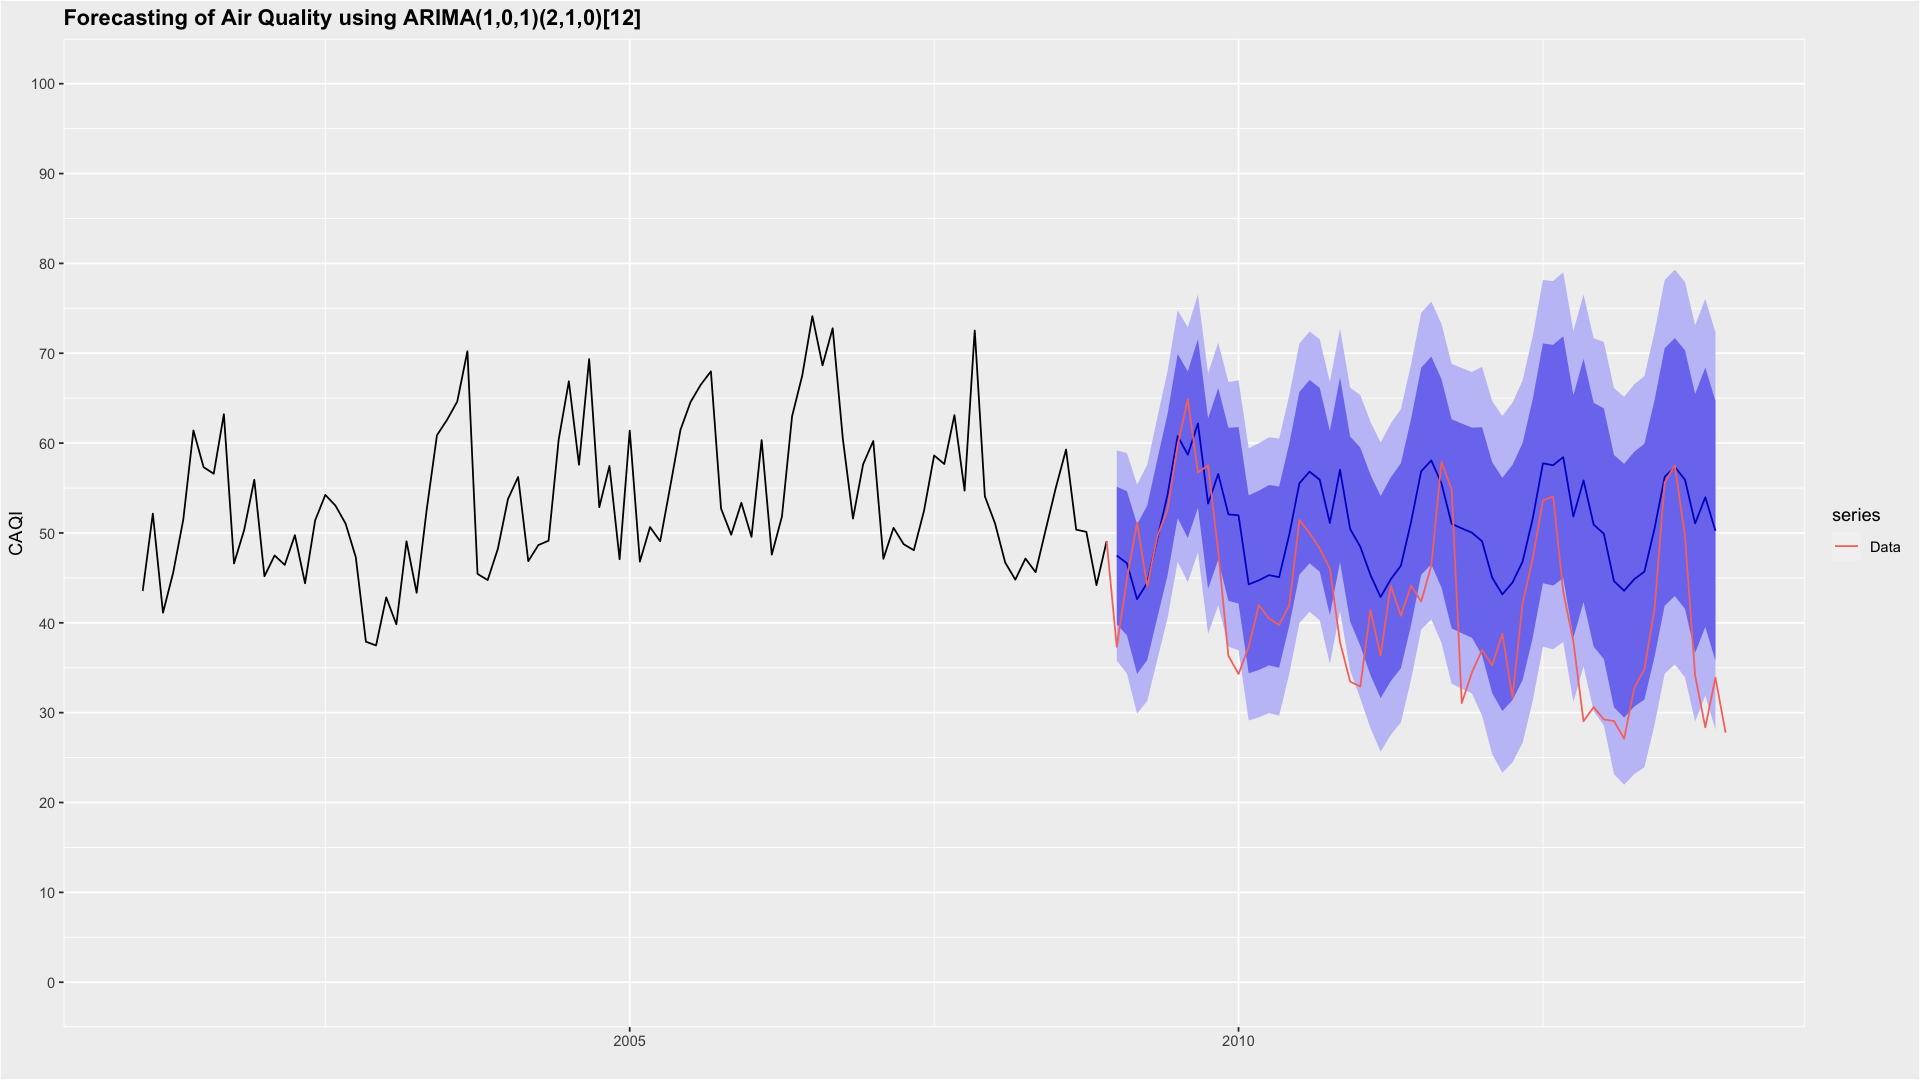

In [36]:
monthly_ts_after09 <- window(monthly_ts, start = c(2008, 12), end = c(2014, 1))

fit_ts %>%
  forecast(h=60) %>%
  autoplot() + 
  theme(axis.text.x = element_text(angle = 0),
        panel.background = element_rect(fill = "gray94", colour = "white",
                                        size = 0.5, linetype = "solid"),
        legend.background = element_rect(fill = "gray94"),
        plot.background = element_rect(fill = "gray94"),
        panel.grid.major = element_line(size = 0.5, linetype = 'solid', colour = "white"), 
        panel.grid.minor = element_line(size = 0.25, linetype = 'solid', colour = "white"),  
        plot.title = element_text(hjust = 0, face = 'bold',color = 'black')) +
  labs(x = '', y = 'CAQI', title='Forecasting of Air Quality using ARIMA(1,0,1)(2,1,0)[12] ') +
  scale_y_continuous(breaks = seq(0,100,10), lim = c(0,100)) +
  autolayer(monthly_ts_after09, series="Data")
ggsave('plots/forecast_before09.png', width = 16, height = 9)

### Forecast the Air Quality in next 5 years (2023)

In [37]:
# Fit an automatic ARIMA model
fit_ts <- auto.arima(monthly_ts)
fit_ts

Series: monthly_ts 
ARIMA(1,0,3)(2,1,0)[12] with drift 

Coefficients:
         ar1      ma1      ma2      ma3     sar1     sar2    drift
      0.9595  -0.6002  -0.0937  -0.0809  -0.7450  -0.3644  -0.0725
s.e.  0.0317   0.0815   0.0855   0.0778   0.0724   0.0717   0.0870

sigma^2 estimated as 35.3:  log likelihood=-630.78
AIC=1277.56   AICc=1278.33   BIC=1303.83

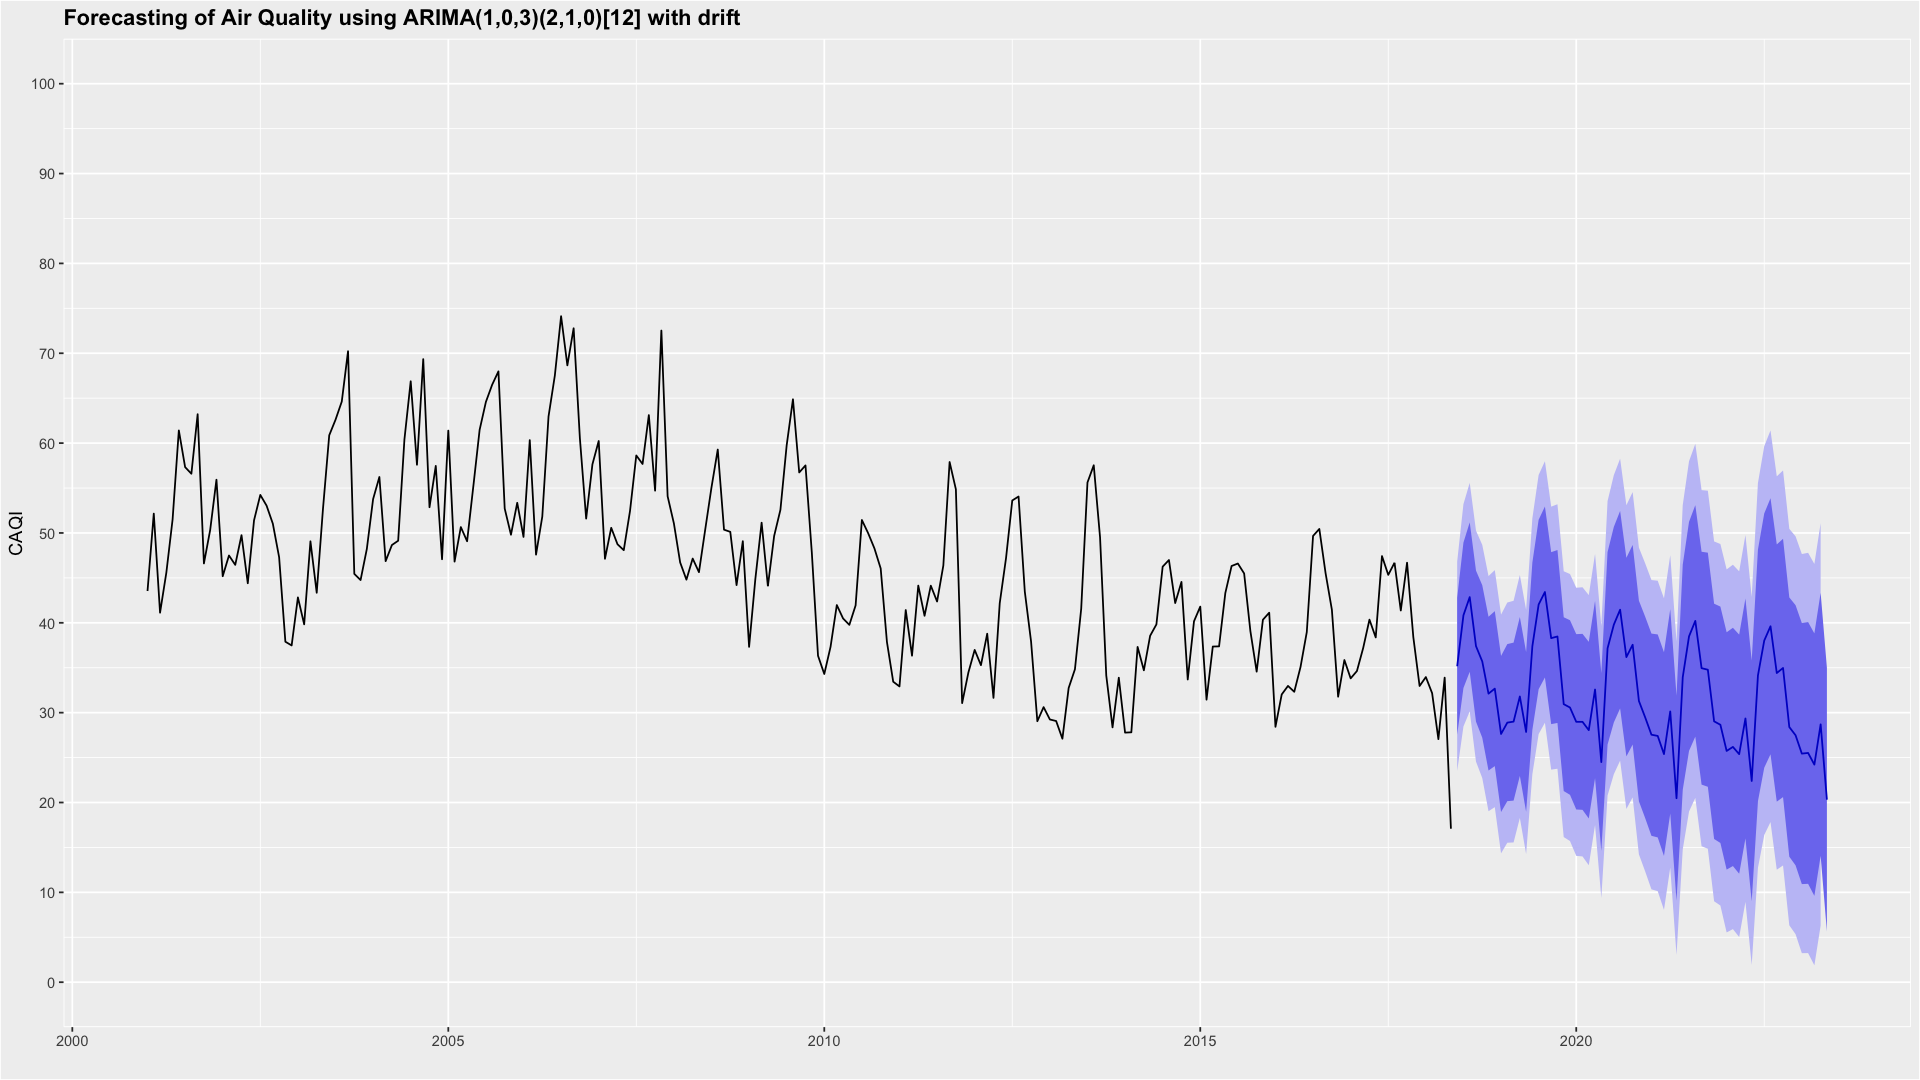

In [38]:
fit_ts %>%
  forecast(h=60) %>%
  autoplot() + 
  theme(axis.text.x = element_text(angle = 0),
        panel.background = element_rect(fill = "gray94", colour = "white",
                                        size = 0.5, linetype = "solid"),
        legend.background = element_rect(fill = "gray94"),
        plot.background = element_rect(fill = "gray94"),
        panel.grid.major = element_line(size = 0.5, linetype = 'solid', colour = "white"), 
        panel.grid.minor = element_line(size = 0.25, linetype = 'solid', colour = "white"),  
        plot.title = element_text(hjust = 0, face = 'bold',color = 'black')) +
  labs(x = '', y = 'CAQI', title='Forecasting of Air Quality using ARIMA(1,0,3)(2,1,0)[12] with drift') +
  scale_y_continuous(breaks = seq(0,100,10), lim = c(0,100))
ggsave('plots/forecast_5years.png', width = 16, height = 9)